In [2]:
!wget https://www.agentspace.org/download/watch.zip
!unzip watch.zip
!rm watch.zip

--2025-10-21 22:50:50--  https://www.agentspace.org/download/watch.zip
Resolving www.agentspace.org (www.agentspace.org)... 62.168.101.9
Connecting to www.agentspace.org (www.agentspace.org)|62.168.101.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6564158 (6.3M) [application/zip]
Saving to: ‘watch.zip.1’

watch.zip.1         100%[===================>]   6.26M  3.86MB/s    in 1.6s    

2025-10-21 22:50:52 (3.86 MB/s) - ‘watch.zip.1’ saved [6564158/6564158]

Archive:  watch.zip
   creating: data/
  inflating: data/1561199394.png     
 extracting: data/1561199394.txt     
  inflating: data/1561199397.png     
 extracting: data/1561199397.txt     
  inflating: data/1561199401.png     
 extracting: data/1561199401.txt     
  inflating: data/1561199403.png     
 extracting: data/1561199403.txt     
  inflating: data/1561199405.png     
 extracting: data/1561199405.txt     
  inflating: data/1561199407.png     
 extracting: data/1561199407.txt     
  inflating: d

data/1561199413.png


ValueError: could not convert string to float: '0.45625.'

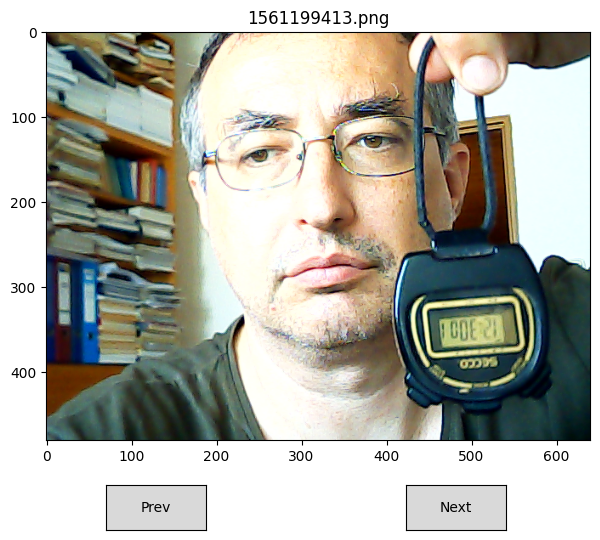

In [4]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.widgets import Button
from IPython.display import display
import ipywidgets as widgets
import cv2
import numpy as np

# Directory with images and annotations
dir = "data"

# === Annotation Data Class ===
class Annotation:
    def __init__(self, classId=0, centerX=0, centerY=0, width=0, height=0):
        self.classId = classId
        self.centerX = centerX
        self.centerY = centerY
        self.width = width
        self.height = height

# === Annotation File I/O ===
def load_annotation(filename):
    annotations = []
    path = os.path.join(dir, filename)
    if not os.path.exists(path):
        return annotations
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 5:
                classId, cx, cy, w, h = map(float, parts[:5])
                annotations.append(Annotation(int(classId), cx, cy, w, h))
    return annotations

def save_annotation(filename, annotations):
    path = os.path.join(dir, filename)
    with open(path, 'w') as f:
        for a in annotations:
            f.write(f"{a.classId} {a.centerX:.6f} {a.centerY:.6f} {a.width:.6f} {a.height:.6f}\n")

def erase_annotation(filename):
    path = os.path.join(dir, filename)
    if os.path.exists(path):
        os.remove(path)

# === Image List ===
images = [f for f in os.listdir(dir) if f.lower().endswith(('.jpg', '.png'))]
if not images:
    raise FileNotFoundError("No images found in data/ directory.")

img_index = 0
annotations = []
rects = []
current_rect = None
start_point = None

# === Matplotlib Figure Setup ===
fig, ax = plt.subplots(figsize=(10, 6))
plt.subplots_adjust(bottom=0.2)
ax.axis('off')

def load_image(index):
    """Load and display the image and its annotations"""
    global annotations, rects, current_rect
    ax.clear()
    img_path = os.path.join(dir, images[index])
    print(img_path)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.set_title(images[index])
    annotations = load_annotation(images[index].replace('.jpg', '.txt').replace('.png', '.txt'))
    rects.clear()
    for ann in annotations:
        h, w = img.shape[:2]
        x = ann.centerX * w - ann.width * w / 2
        y = ann.centerY * h - ann.height * h / 2
        rect = patches.Rectangle((x, y), ann.width * w, ann.height * h,
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        rects.append(rect)
    fig.canvas.draw()

# === Mouse Events ===
def on_press(event):
    global start_point, current_rect
    if event.inaxes != ax:
        return
    start_point = (event.xdata, event.ydata)
    current_rect = patches.Rectangle(start_point, 1, 1, linewidth=2, edgecolor='y', facecolor='none')
    ax.add_patch(current_rect)
    fig.canvas.draw()

def on_release(event):
    global start_point, current_rect
    if event.inaxes != ax or current_rect is None:
        return
    end_point = (event.xdata, event.ydata)
    x0, y0 = start_point
    x1, y1 = end_point
    w = abs(x1 - x0)
    h = abs(y1 - y0)
    x = min(x0, x1)
    y = min(y0, y1)
    img = ax.images[0].get_array()
    H, W = img.shape[:2]
    ann = Annotation(
        classId=0,
        centerX=(x + w / 2) / W,
        centerY=(y + h / 2) / H,
        width=w / W,
        height=h / H
    )
    annotations.append(ann)
    current_rect.set_edgecolor('r')
    rects.append(current_rect)
    current_rect = None
    start_point = None
    fig.canvas.draw()

def on_motion(event):
    if start_point is None or current_rect is None or event.inaxes != ax:
        return
    x0, y0 = start_point
    x1, y1 = event.xdata, event.ydata
    current_rect.set_width(x1 - x0)
    current_rect.set_height(y1 - y0)
    current_rect.set_xy((x0, y0))
    fig.canvas.draw_idle()

# === Buttons for Navigation ===
def next_image(event=None):
    global img_index
    save_current()
    img_index = (img_index + 1) % len(images)
    load_image(img_index)

def prev_image(event=None):
    global img_index
    save_current()
    img_index = (img_index - 1) % len(images)
    load_image(img_index)

def save_current():
    txt = images[img_index].replace('.jpg', '.txt').replace('.png', '.txt')
    if annotations:
        save_annotation(txt, annotations)
    else:
        erase_annotation(txt)

ax_prev = plt.axes([0.3, 0.05, 0.1, 0.075])
ax_next = plt.axes([0.6, 0.05, 0.1, 0.075])
bnext = Button(ax_next, 'Next')
bprev = Button(ax_prev, 'Prev')
bnext.on_clicked(next_image)
bprev.on_clicked(prev_image)

# === Event Binding ===
fig.canvas.mpl_connect('button_press_event', on_press)
fig.canvas.mpl_connect('button_release_event', on_release)
fig.canvas.mpl_connect('motion_notify_event', on_motion)

# === Start ===
load_image(img_index)
plt.sho
